``Objective``
* Perform multiclass classification using logistic regression. 

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task.

``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [160]:
!pip install keras-tuner

%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters
from tensorflow import keras
from tensorflow.keras import initializers

from sklearn.preprocessing import StandardScaler, LabelEncoder

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

### Define functions

In [161]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )

    return df

In [162]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15

    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

In [163]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


In [164]:
# 1. Number of columns
num_columns = df.shape[1]
print(f"Number of columns: {num_columns}")

# 2. Number of rows
num_rows = df.shape[0]
print(f"Number of rows: {num_rows}")

# 3. Column names
column_names = df.columns.tolist()
print("Column names:", column_names)

# 4. Number of unique values
unique_values = df.nunique()
print("Number of unique values per column:\n", unique_values)

# 5. Unique values in 'cocoa_percent' column
unique_cocoa_percent = df['cocoa_percent'].unique()
print("Unique cocoa_percent values:", unique_cocoa_percent)

Number of columns: 9
Number of rows: 1795
Column names: ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']
Number of unique values per column:
 maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64
Unique cocoa_percent values: [ 63.   70.   60.   80.   88.   72.   55.   75.   65.   85.   73.   64.
  66.   68.   50.  100.   77.   90.   71.   83.   78.   74.   76.   86.
  82.   69.   91.   42.   61.   73.5  62.   67.   58.   60.5  79.   81.
  57.   72.5  56.   46.   89.   99.   84.   53.   87. ]


In [165]:
# Outcome vairable : cocoa_percent into low, medium, and high.
bins = [0, 65, 80, 100]
labels = [0, 1, 2] # "0=low," "1=medium," and "2=high
df['cocoa_category'] = pd.cut(df['cocoa_percent'], bins=bins, labels=labels)

print(df[['cocoa_percent', 'cocoa_category']].head())





   cocoa_percent cocoa_category
0          63.00              0
1          70.00              1
2          70.00              1
3          70.00              1
4          70.00              1


---
### Step 2: Data preprocessing

In [166]:
# 1. Suffle the data

np.random.seed(0)

# Create a list of indices
indices = np.arange(df.shape[0])
print(indices)

# Shuffle indices
shuffled_indices = np.random.permutation(indices)
print(shuffled_indices)

# change the ordering of the data
df = df.reindex(shuffled_indices)
df.head()


[   0    1    2 ... 1792 1793 1794]
[1368 1705  927 ... 1653  559  684]


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,cocoa_category
1368,Republica del Cacao (aka Confecta),"Los Rios,Vinces",439,2009,75.00,Ecuador,2.50,Forastero (Arriba),Ecuador,1
1705,Vao Vao (Chocolaterie Robert),Madagascar,404,2009,72.00,Madagascar,2.75,Trinitario,Madagascar,1
927,La Chocolaterie Nanairo,"Lumas,2015 Harvest,Batch 7",1892,2016,70.00,Japan,2.50,"Criollo, Trinitario",Peru,1
713,Friis Holm (Bonnat),"Chuno,double turned,Xoco",899,2012,70.00,Denmark,3.25,"Criollo, Trinitario",Nicaragua,1
262,Brazen,Elvesia P,1514,2015,80.00,U.S.A.,3.25,Blend,Dominican Republic,1


In [167]:
# 2. Feature selection

# create Y data frame
Y = df['cocoa_category']
print(Y.shape)

# create X data frame
X = df[['maker_location', 'bean_type', 'review_date', 'reference_number']]
print(X.shape)

(1795,)
(1795, 4)


In [168]:
# 3. Create training, validation, and test datasets using a 60/20/20 split

# Split (X,Y) data into training and temp paritions
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=1234)
# Split (X_temp,Y_temp) data into validation and test paritions
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 1077
Validation set size: 359
Test set size: 359


In [169]:
# 4. Perform necessary cleaning and standarization on the features.

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

print(categorical_features)
print(numerical_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Fit Preprocessor only on X_train, transform all
X_train_std = preprocessor.fit_transform(X_train)
X_val_std = preprocessor.transform(X_val)
X_test_std = preprocessor.transform(X_test)


print("X_train_std shape:", X_train_std.shape)
print("X_val_std shape:", X_val_std.shape)
print("X_test_std shape:", X_test_std.shape)

Index(['maker_location', 'bean_type'], dtype='object')
Index(['review_date', 'reference_number'], dtype='object')
X_train_std shape: (1077, 85)
X_val_std shape: (359, 85)
X_test_std shape: (359, 85)


---
### Step 3: Exploratory data analysis (EDA)

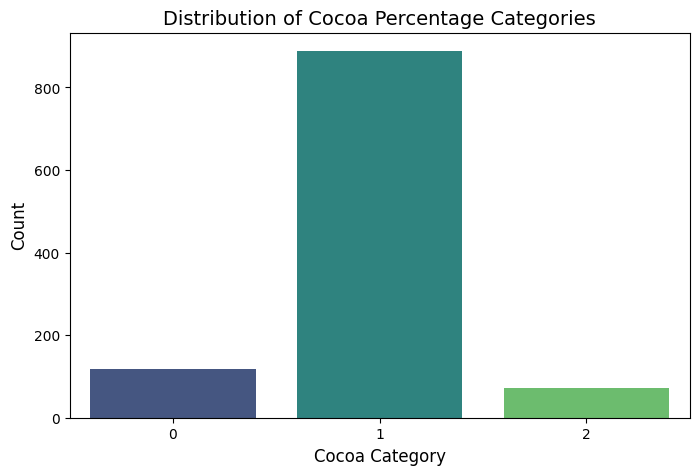

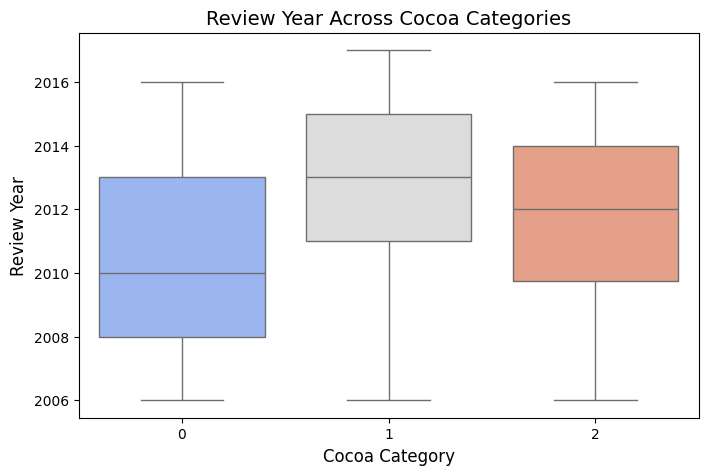

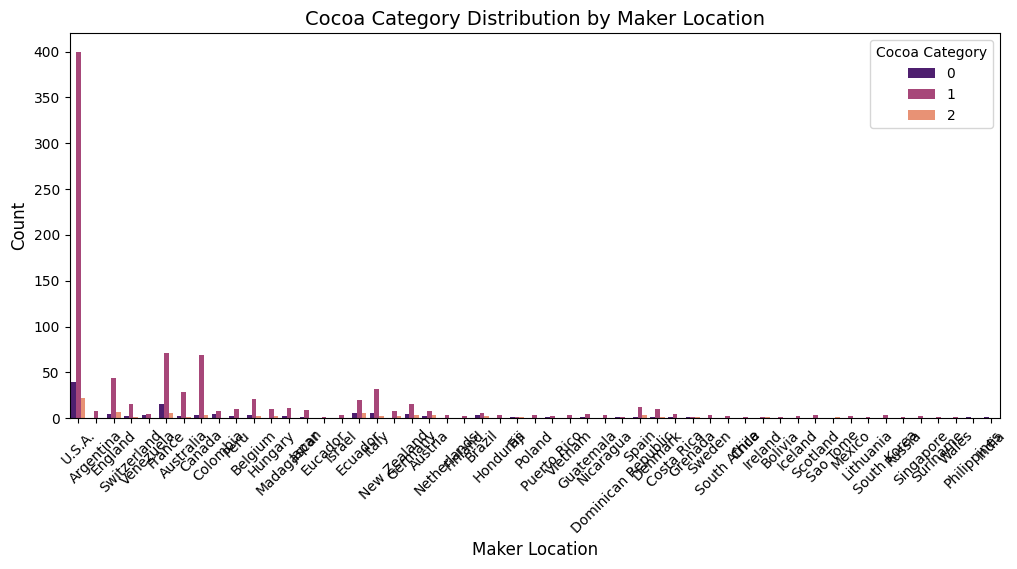

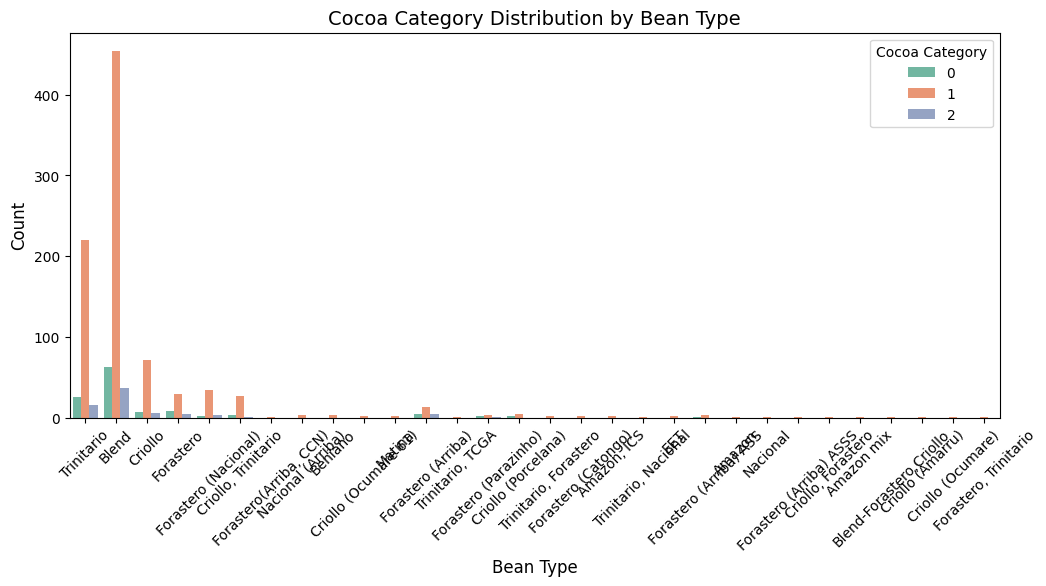

In [170]:
import seaborn as sns


df_train = pd.concat([pd.DataFrame(Y_train, columns=['cocoa_category']), pd.DataFrame(X_train)], axis=1)
df_train.head()

# Plot 1 :  Distribution of Cocoa Categories
plt.figure(figsize=(8, 5))
sns.countplot(x='cocoa_category', data=df_train, palette='viridis')
plt.title('Distribution of Cocoa Percentage Categories', fontsize=14)
plt.xlabel('Cocoa Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()
# The plot 1 shows that category 1 (medium cocoa percentage) appears more frequently
# than 0 (Low) and 2 (High).


# PLOT 2: Cocoa Category vs Review Date
plt.figure(figsize=(8, 5))
sns.boxplot(x='cocoa_category', y='review_date', data=df_train, palette='coolwarm')
plt.title('Review Year Across Cocoa Categories', fontsize=14)
plt.xlabel('Cocoa Category', fontsize=12)
plt.ylabel('Review Year', fontsize=12)
plt.show()
# The boxplot shows that medium cocoa percentage (category 1) has a higher mean review year.

# PLOT 3: Cocoa Category by Maker Location
plt.figure(figsize=(12, 5))
sns.countplot(x='maker_location', hue='cocoa_category', data=df_train, palette='magma')
plt.title('Cocoa Category Distribution by Maker Location', fontsize=14)
plt.xlabel('Maker Location', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cocoa Category')
plt.show()
# The U.S. has the highest count for all three cocoa categories.
# Some other maker locations show a similar trend across cocoa categories.

# PLOT 4: Cocoa Category by Bean Type
plt.figure(figsize=(12, 5))
sns.countplot(x='bean_type', hue='cocoa_category', data=df_train, palette='Set2')
plt.title('Cocoa Category Distribution by Bean Type', fontsize=14)
plt.xlabel('Bean Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cocoa Category')
plt.show()
# The two most common bean types appear across all three cocoa categories.

---
### Step 4: Modeling

In [171]:
print("number of medium cocoa percentage in Y_train:", np.sum(Y_train == 1))
print("number of low and high cocoa percentage in Y train:", np.sum(Y_train != 1))

bsl_accuracy = np.sum(Y_train == 1) / len(Y_train)
print("baseline accuracy:", bsl_accuracy)



def ce_loss(preds, Y):
  """
    preds are (m,n) m = number of examples, n = number of classes
    Y is (m,) -- array of sparse labels
    preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
  """
  # Get the number of examples
  m = Y.shape[0]

  # Compute the first sum, the cross-entropy for each example, using
  # the rows of the predictions and corresponding labels.
  # Note that we need the dense (one-hot) labels.
  Y_dense = tf.keras.utils.to_categorical(Y)
  # [.1, .1, .8] [0, 0, 1] -> [0, 0, -1*log(.8)] -> -1*log(.8)
  cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

  # Here's a more efficient but tricky way to do this:
  # cross_entropy_values = -np.log(preds[range(m), Y])

  # Sum the per-example cross-entropy values.
  loss = np.sum(cross_entropy_values) / m

  return loss

# Compute class probability
total_samples = len(Y_train)
class_1_prob = np.sum(Y_train == 1) / total_samples
other_class_prob = (1 - class_1_prob) / 2

print("class_1_prob", class_1_prob)
print("other_class_prob", other_class_prob)

# Create a baseline probability distribution for all
bsl_prob_train = np.full((len(Y_train), 3), other_class_prob)
bsl_prob_train[:, 1] = class_1_prob

bsl_prob_val = np.full((len(Y_val), 3), other_class_prob)
bsl_prob_val[:, 1] = class_1_prob

# Compute baseline log loss for Y_train and Y_val
ce_loss_Y_train = ce_loss(bsl_prob_train, Y_train)
ce_loss_Y_val = ce_loss(bsl_prob_val, Y_val)

print(f"Baseline Log Loss (Train): {ce_loss_Y_train:.4f}")
print(f"Baseline Log Loss (Val): {ce_loss_Y_val:.4f}")


number of medium cocoa percentage in Y_train: 888
number of low and high cocoa percentage in Y train: 189
baseline accuracy: 0.8245125348189415
class_1_prob 0.8245125348189415
other_class_prob 0.08774373259052926
Baseline Log Loss (Train): 0.5861
Baseline Log Loss (Val): 0.6360


In [172]:
# 1. Build a model

def build_model(num_features, learning_rate):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)


  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()

    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))

    # create output layer
    model.add(keras.layers.Dense(
          units=3,  # remember it's a multiclass classification problem
          use_bias=True,
          activation='softmax', # remember it's a multiclass classification problem
          kernel_initializer=initializers.RandomNormal(stddev=0.01),
          bias_initializer=initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))

  # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

print(X_train_std.shape[1])
model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=0.0001)
model_tf.summary()


85


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Output (Dense)                       │ (None, 3)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258 (1.01 KB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

In [173]:
# 2. Train model

Y_train = np.array(Y_train)  # Convert from pandas Series
Y_val = np.array(Y_val)      # Convert validation labels too

tf.random.set_seed(1234)
np.random.seed(1234)

hist= model_tf.fit(x=X_train_std,
                y=Y_train,
                validation_data=[X_val_std, Y_val],
                batch_size=32,
                epochs=10,
                verbose=1
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4083 - loss: 1.0981 - val_accuracy: 0.4067 - val_loss: 1.0970
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4313 - loss: 1.0961 - val_accuracy: 0.4067 - val_loss: 1.0952
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4594 - loss: 1.0941 - val_accuracy: 0.4373 - val_loss: 1.0933
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4865 - loss: 1.0921 - val_accuracy: 0.5014 - val_loss: 1.0915
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5202 - loss: 1.0901 - val_accuracy: 0.5320 - val_loss: 1.0897
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5644 - loss: 1.0881 - val_accuracy: 0.5710 - val_loss: 1.0878
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6058 - loss: 1.0861 - val_accuracy: 0.5933 - val_loss: 1.0860
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6376 - loss: 1.0842 - val_accuracy: 0.6156 - v

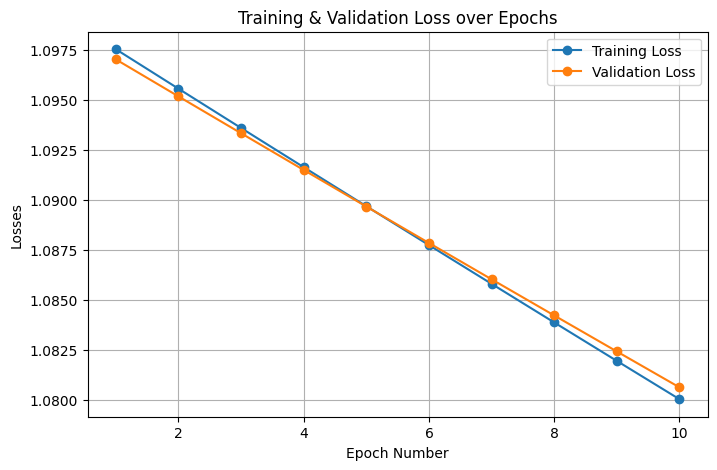

In [174]:
# 3. Generate plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), hist.history['loss'], label='Training Loss', marker='o')
plt.plot(range(1, 11), hist.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch Number')
plt.ylabel('Losses')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

---
### Step 5: Hyperparameter tuning

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Output (Dense)                       │ (None, 3)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258 (1.01 KB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7371 - loss: 0.9495 - val_accuracy: 0.8022 - val_loss: 0.7338
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8341 - loss: 0.6585 - val_accuracy: 0.8022 - val_loss: 0.6616
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8341 - loss: 0.5890 - val_accuracy: 0.8022 - val_loss: 0.6435
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8341 - loss: 0.5659 - val_accuracy: 0.8022 - val_loss: 0.6380
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8341 - loss: 0.5559 - val_accuracy: 0.8022 - val_loss: 0.6360
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8341 - loss: 0.5508 - val_accuracy: 0.8022 - val_loss: 0.6350
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8341 - loss: 0.5476 - val_accuracy: 0.8022 - val_loss: 0.6343
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8341 - loss: 0.5454 - val_accuracy: 0.8022 - v

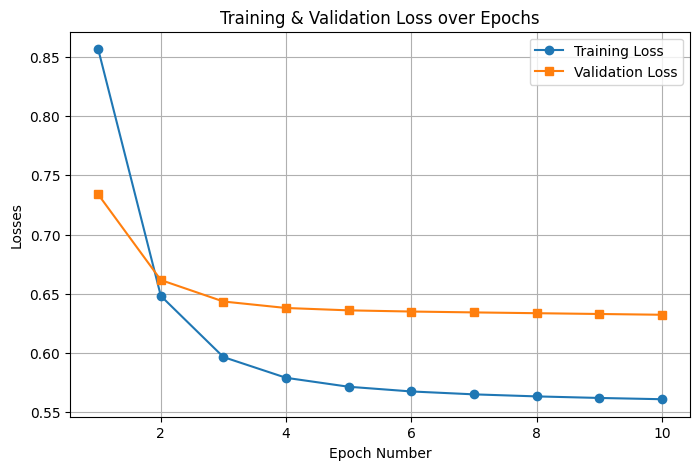

Loss at the final epoch on training set: 0.560998
Loss at the final epoch on validation set: 0.632281
Percentage difference between train and val loss: 12.706444
Training Loss Improvement (%): 4.286220
Validation Loss Improvement (%): 0.591822
First five learned parameters (including bias):
[-0.14551568  0.1013729   0.05169809 -0.11484104]
[-0.4356947]


In [175]:
tf.random.set_seed(0)
# 2. Build and compile model
model_tf = build_model(
    num_features=X_train_std.shape[1],
    learning_rate=0.04
)

model_tf.summary()

# 3. Fit the model
fit_tf = model_tf.fit(
    x = X_train_std,
    y = Y_train,
    validation_data=(X_val_std, Y_val),
    epochs=10,
    batch_size=32,
    verbose=1)

# Extract loss values
train_loss = fit_tf.history['loss']
val_loss = fit_tf.history['val_loss']

# 4. Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch Number')
plt.ylabel('Losses')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

loss_tf = fit_tf.history['loss'][-1]
val_loss_tf = fit_tf.history['val_loss'][-1]
print(f"Loss at the final epoch on training set: {loss_tf:.6f}")
print(f"Loss at the final epoch on validation set: {val_loss_tf:.6f}")

loss_diff_percentage = abs((loss_tf - val_loss_tf) / loss_tf) * 100
print(f"Percentage difference between train and val loss: {loss_diff_percentage:.6f}")

train_improvement = (ce_loss_Y_train - loss_tf) / ce_loss_Y_train * 100
val_improvement = (ce_loss_Y_val - val_loss_tf) / ce_loss_Y_val * 100
print(f"Training Loss Improvement (%): {train_improvement:.6f}")
print(f"Validation Loss Improvement (%): {val_improvement:.6f}")

weights, bias = model_tf.layers[0].get_weights()
weights_flat = weights.flatten()
bias_flat = bias.flatten()
print("First five learned parameters (including bias):")
print(weights_flat[:4])
print(bias_flat[:1])

---
### Step 6: Evaluation and generalization

In [176]:
from sklearn.metrics import accuracy_score


# Get predicted prob.
Y_train_pred_proba = model_tf.predict(X_train_std)
Y_test_pred_proba = model_tf.predict(X_test_std)

# Convert probabilities to class labels
Y_train_pred = np.argmax(Y_train_pred_proba, axis=1)
Y_test_pred = np.argmax(Y_test_pred_proba, axis=1)

# Compute accuracy
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

# Print results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# The model shows strong generalization capabilities because
# train and test accuracies are close (difference of ~2.5%).

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Train Accuracy: 0.8245
Test Accuracy: 0.7994


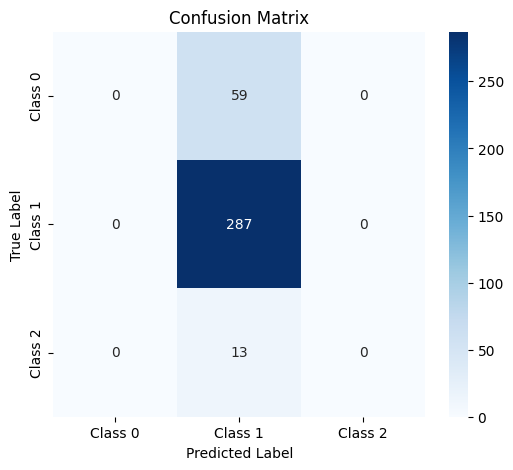

array([[  0,  59,   0],
       [  0, 287,   0],
       [  0,  13,   0]])

In [177]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y_test, Y_test_pred)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["Class 0", "Class 1", "Class 2"]

plot_confusion_matrix(conf_matrix, class_names)

conf_matrix


# 1: The model confuses Class 0 the most. It misclassified 59 examples as Class 1.
# 2: Precision = TP/ (TP + FP). Class 1 has the lowest precision (0.799)
#    Class 0 is the largest source of false positives
# 3: Recall = TP/ (TP + FN). Class 0 & 2 have the lowest recall (0)
#    class 0 has the largest source of false negatives.
